In [1]:
!sudo apt-get update
!sudo apt-get install wget
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7" -O data.zip && rm -rf /tmp/cookies.txt
from zipfile import ZipFile
with ZipFile('./drive/My Drive/acse-miniproject.zip', 'r') as zipObj:
    print("Started unzipping... \n")
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    print("Files unziped sucessfully\n")
!ls

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [92.1 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 k

In [1]:
#livelossplot setup
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

# device = 'cpu'
device = torch.device("cuda:0")
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [0]:
# Other Hyperparameters
seed = 42
lr = 0.1
momentum = 0.9
batch_size = 32
test_batch_size = 1000
n_epochs = 5

In [0]:
train_data_path = './train'  #'/kaggle/input/acse-miniproject/train' #

In [5]:
import glob
from PIL import Image
import numpy as np
import pandas as pd
import json 

#'/content/drive/My Drive/Logistic/mapping.json' /kaggle/input/acse-miniproject/mapping.json
with open("./mapping.json",'r', encoding='UTF-8') as f:
     load_dict = json.load(f)


train_file = glob.glob(train_data_path+'/*/images/*.JPEG')
print(len(train_file))
train_data = []
labels = []
count = 0


for f in train_file:
    img = np.array(Image.open(f))
    label_name = f.split('/')[2] #[5] #
    # print(label_name)
    label = load_dict.get(label_name)
    if img.shape != (64,64,3):
        img = np.stack((img,)*3, axis=-1)
        # img = Image.fromarray(np.uint8(img))
        # img = np.asarray(img.convert('RGB'))
    
    train_data.append(img)
    labels.append(label)
    count += 1

print(len(train_data))

100000
100000


In [6]:
train_data = np.array(train_data)
labels = np.array(labels)
print(train_data.shape)
print(labels.shape)

# mean = train_data.mean(axis=(0,1,2))/255
# std = train_data.std(axis=(0,1,2))/255
mean=[0.4802, 0.4481, 0.3975]
std=[0.2770, 0.2691, 0.2821]

print(mean)
print(std)

(100000, 64, 64, 3)
(100000,)
[0.4802, 0.4481, 0.3975]
[0.277, 0.2691, 0.2821]


In [7]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_data, labels)

indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
#valid_idx = list(set(train_idx).difference(set(train_dataset)))

print(len(indices[0]))
print(len(indices[1]))

90000
10000


In [8]:
X_train, y_train = torch.tensor(train_data[indices[0]]).float(), torch.tensor(labels)[indices[0]]
X_val, y_val = torch.tensor(train_data[indices[1]]).float(), torch.tensor(labels)[indices[1]]


X_train = X_train.permute(0,3,1,2)
X_val = X_val.permute(0,3,1,2)


print(X_train.size())
print(X_val.size())
print(y_train.size())

torch.Size([90000, 3, 64, 64])
torch.Size([10000, 3, 64, 64])
torch.Size([90000])


In [0]:
from torch.utils.data import Dataset 

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        #sample = sample.view(3, 64, 63).float()/255.
        if self.transform:
            sample = self.transform(sample)


        return sample, label

In [0]:
import torchvision

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_transform = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ColorJitter(contrast=0.1),
    # transforms.RandomCrop(224, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0.0, 0.05)], p = 0.1),
    transforms.Normalize(mean, std)])

valid_transform = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

train_set = CustomImageTensorDataset(X_train, y_train.long(), transform=train_transform)
valid_set = CustomImageTensorDataset(X_val, y_val.long(), transform=valid_transform)

In [0]:
#SIMPLE SET TO LOADTER
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [0]:
#train + validate + evaluate
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
#     t = 1
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
#         a2 = model(X)
        a2 = model(X.view(-1, 3, 224, 224)) 
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
#             a2 = model(X)
            a2 = model(X.view(-1, 3, 224, 224))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            # a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
def exp_lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epoch=3):
    """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""
    if epoch % lr_decay_epoch:
        return optimizer
    
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay
    return optimizer

In [0]:
######### 模型定义 #########

def weights_init_xavier(mm):
  for m in mm.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=1)
            # print(m.weight)

class MyModel(nn.Module):
    def __init__(self):   # input the dim of output fea-map of Resnet:
        super(MyModel, self).__init__()
        
        BackBone = models.wide_resnet50_2(pretrained=True)
        self.resnet_layer = nn.Sequential(*list(BackBone.children())[:-2])
        
        self.transion_layer = nn.ConvTranspose2d(2048, 2048, kernel_size=14, stride=3)
        self.pool_layer = nn.MaxPool2d(32)  
        self.Linear_layer = nn.Linear(2048, 200).apply(weights_init_xavier)

        # add_block = []
        # add_block += [nn.Linear(1000, 512)]
        # add_block += [nn.LeakyReLU(inplace=True)]
        # add_block = nn.Sequential(*add_block)
        # add_block.apply(weights_init_xavier)
 
        # self.BackBone = BackBone
        # self.add_block = add_block
 
 
    def forward(self, input):   # input is 2048!
        # print(input.shape)
        # x = self.BackBone(input)
        # print(x.shape)
        # x = self.add_block(x)

        x = self.resnet_layer(x)
 
        x = self.transion_layer(x)
 
        x = self.pool_layer(x)
 
        x = x.view(x.size(0), -1) 
 
        x = self.Linear_layer(x)
 
        return x

 
# 模型准备
model = MyModel()
 
# 优化、正则项、权重设置与冻结层
 
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.add_block.parameters():
#     param.requires_grad = True
 
optimizer = optim.SGD(
            model.parameters(),  
            lr=0.01,
            weight_decay=1e-5, momentum=0.9, nesterov=True)
 


In [20]:
# Finetuning
import torchvision.models as models
import torch.optim as optim

model = models.wide_resnet101_2(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 200)
 
if torch.cuda.is_available():
    model = model.cuda()

# def train_model(model, optimizer, weight_decay = 0., bias = True):
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=0)
set_seed(seed)
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    # if epoch < 10: optimizer = exp_l r_scheduler(optimizer, epoch)
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
#         print(train_loss.item(), train_accuracy.item())
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
#     print(train_loss.item(), train_accuracy.item())
    validation_loss, validation_accuracy = validate(model, criterion, valid_loader)
#         print(validation_loss.item(), validation_accuracy.item())
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

    # return model, liveloss


RuntimeError: ignored

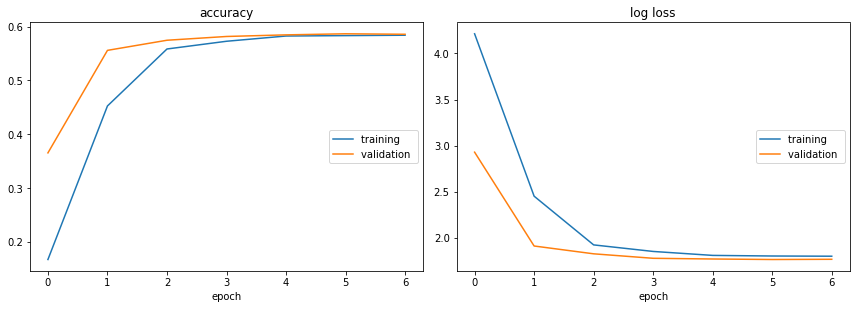

accuracy
	training         	 (min:    0.167, max:    0.584, cur:    0.584)
	validation       	 (min:    0.365, max:    0.587, cur:    0.586)
log loss
	training         	 (min:    1.798, max:    4.214, cur:    1.798)
	validation       	 (min:    1.762, max:    2.928, cur:    1.764)


KeyboardInterrupt: ignored

In [0]:
# Finetuning
import torchvision.models as models
import torch.optim as optim

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)
 
if torch.cuda.is_available():
    model_ft = model_ft.cuda()
    
# def train_model(model, optimizer, weight_decay = 0., bias = True):
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4)
model = train_model(model_ft, optimizer_ft)
set_seed(seed)
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    # optimizer = exp_lr_scheduler(optimizer, epoch)
#         print(epoch)
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
#         print(train_loss.item(), train_accuracy.item())
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
#     print(train_loss.item(), train_accuracy.item())
    validation_loss, validation_accuracy = validate(model, criterion, valid_loader)
#         print(validation_loss.item(), validation_accuracy.item())
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

    # return model, liveloss


In [0]:
# Finetuning
import torchvision.models as models
import torch.optim as optim

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)
 
if torch.cuda.is_available():
    model_ft = model_ft.cuda()
    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
del train_file
del X_train, y_train, X_val, y_val, shuffler, indices, mean, std, train_data, labels
del img, label_name

In [0]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4)
model_ft = train_model(model_ft, optimizer_ft)

In [18]:
import glob
from PIL import Image
import numpy as np
import pandas as pd
import json 
data_path='./test/'
# test_transform = torchvision.transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2770, 0.2691, 0.2821])])
# test_dataset = torchvision.datasets.ImageFolder(
#         root=data_path,
#         transform=test_transform)
test_file = glob.glob('./test/images/*.JPEG') #'/content/drive/My Drive/Logistic/train/images/*.JPEG'
print(len(test_file))
test_data = []
test_names = []
for f in test_file:
    
    img = np.array(Image.open(f))
    test_name = f.split('/')[3][5:-5] #[7][5:-5] 
    #label = load_dict.get(label_name)
    if img.shape != (64,64,3):
        img = np.stack((img,)*3, axis=-1)
    test_data.append(img)
    test_names.append(int(test_name))
print(test_names[:5])
#y_test is only used for generating dataset. it's not the real labels
y_test = np.array(test_names)
y_test = torch.tensor(y_test)
 
X_test = np.array(test_data)
X_test = torch.tensor(X_test).float()
X_test = X_test.permute(0,3,1,2)
 
test_set = CustomImageTensorDataset(X_test, y_test.long(), transform=valid_transform)
test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=1000,
        num_workers=0,
        shuffle=False
)


10000
[2188, 5321, 3946, 2657, 9941]


In [21]:
y_pred, y_gt = evaluate(model, test_loader)
y_pred[:5], y_gt[:5]
res = {}
for i in range(10000):
    res["test_" + str(y_gt[i]) + ".jpeg"] = y_pred[i]
res
import csv
#'/content/drive/My Drive/Logistic/resnet50.csv'
with open('/content/drive/My Drive/wideresnet101_0_64_1e-1adp.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Label"])
    for key, item in res.items():
        writer.writerow([key, item])

RuntimeError: ignored

In [0]:
torch.save(model, '/content/drive/My Drive/wideresnet101_0_64_1e-1adp.pth')